# ENEL ACCESSIBILITY: Speech-to-text transcripts from Amazon Transcribe using custom vocabularies and Amazon Augmented AI
### Objective of this Notebook is to provide a POC environment for ENEL in order to automate caption and human review workflow for internal video for education purposes.

### demo is based on two video from you tube uploaded in a local input folder inside this JN
### https://www.youtube.com/watch?v=Va27qoChrqI
### https://www.youtube.com/watch?v=9-GTaopuMhU

# Setup

### Install Latest SDKs

In [13]:
# First, let's get the latest installations of our dependencies
# Following pip install are not required as you run it in a SM Studio NB
# !pip install --upgrade pip --quiet
# !pip install --upgrade awscli --quiet
# !pip install -U botocore --quiet
!pip install boto3 --upgrade --quiet

In [3]:
import io
import uuid
import botocore
import boto3
import re
import time
import pprint
import subprocess
import json
import sagemaker
from sagemaker import get_execution_role
from datetime import datetime, timezone

### Region, Bucket, and Paths
Make sure all your resources are stored in the same region.Bucket needs to be created upfront (in the same region as Notebook)

In [8]:
BUCKET = 'cris-transcribe-accessibility-2' #Add your bucket name here

if(BUCKET==''):
    BUCKET = sagemaker.Session().default_bucket()
print(f'The S3 bucket used in this demo will be: {BUCKET}')

#path output service Augmented AI
OUTPUT_PATH_A2I = f's3://{BUCKET}/a2i-results'
#path output service transcribe
OUTPUT_PATH_TRANSCRIBE = f's3://{BUCKET}/transcribe-results'

The S3 bucket used in this demo will be: cris-transcribe-accessibility-2


In [9]:
sess = sagemaker.session.Session()
role = sagemaker.get_execution_role()
region = boto3.session.Session().region_name

# Amazon S3 (S3) client
s3 = boto3.client('s3', region)
bucket_region = s3.head_bucket(Bucket=BUCKET)['ResponseMetadata']['HTTPHeaders']['x-amz-bucket-region']
assert bucket_region == region, "Your S3 bucket {} and this notebook need to be in the same region.".format(BUCKET)

##We will use 3 services: SageMaker, Augmeted AI (optional), Transcribe
# Amazon SageMaker client
sagemaker_client = boto3.client('sagemaker')

# Amazon Augment AI (A2I) client
a2i = boto3.client('sagemaker-a2i-runtime')

# Amazon Transcribe client
transcribe_client = boto3.client("transcribe")

### Roles and Permissions

This is the execution role that will be used to call Amazon Transcribe and Amazon A2I. 

In [10]:
from sagemaker import get_execution_role

ROLE = get_execution_role()
display(ROLE)

'arn:aws:iam::733414849973:role/service-role/AmazonSageMaker-ExecutionRole-20220509T151731'

Add the following policies to this role in IAM:
* AmazonAugmentedAIFullAccess
* AmazonTranscribeFullAccess

Your execution role has the AmazonSageMakerFullAccess policy attached. This gives Amazon SageMaker permission to access your resources in S3 if the bucket or objects have the word `sagemaker` in the name. If your S3 bucket listed in `BUCKET` does not have sagemaker in the name, you will need to add an S3 policy to your execution role to give your role permissions to access your data objects in S3. The following is an example of an S3 policy:

```
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "s3:GetObject"
            ],
            "Resource": [
                "arn:aws:s3:::my_input_bucket/*"
            ]
        },
        {
            "Effect": "Allow",
            "Action": [
                "s3:PutObject"
            ],
            "Resource": [
                "arn:aws:s3:::my_output_bucket/*"
            ]
        }
    ]
}
```


Note: your default **Maximum CLI/API session duration** (MaxSessionDuration) for this execution role is 1 hour. It is recommended that you [increase MaxSessionDuration](https://docs.aws.amazon.com/IAM/latest/UserGuide/roles-managingrole-editing-console.html#roles-modify_max-session-duration) to 2 hours. If you take more than `MaxSessionDuration`-hours to complete the notebook, you may have to re-run previous code cells, and all code cells that define functions below. 

### Upload Sample Video to S3


In [11]:
!rm -rf ./a2i_transcribe_demo*

### load the file from your environment into your s3 bucket 

In [12]:
%%bash -s "$BUCKET"
aws s3 cp ./Input/ s3://$1/input/ --recursive


The user-provided path ./Input/ does not exist.


CalledProcessError: Command 'b'aws s3 cp ./Input/ s3://$1/input/ --recursive\n'' returned non-zero exit status 255.

In [94]:
%%bash -s "$BUCKET"
aws s3 ls s3://$1/input/

2022-02-07 11:53:07   29486628 L'intervista a Francesco Starace amministratore delegato di Enel.mp4
2022-02-07 11:53:07   11422574 Nascita e crescita di Enel - Enel Frammenti di storia.mp4


In [95]:
%%capture cap_out --no-stderr
%%bash -s "$BUCKET"
aws s3 ls s3://$1/input/ --recursive

The following cell will define the variable `all_videos`. This will determine the number of videos that you will use. 

In [96]:
VIDEOS = cap_out.stdout
all_videos = re.findall("input/.*",VIDEOS)
for i in range(len(all_videos)):
    all_videos[i] = all_videos[i].split('input/')[-1]
all_videos

["L'intervista a Francesco Starace amministratore delegato di Enel.mp4",
 'Nascita e crescita di Enel - Enel Frammenti di storia.mp4']

In [97]:
num_videos = len(all_videos)
num_videos

2

In [98]:
# You can give each transcription job any name. We attach a timestamp to each job name here
# to prevent conflicting job names in case we need to re-run any jobs.
now = datetime.now()
time_now = now.strftime("%H.%M.%S")

# Path to folder
folder_path = f"s3://{BUCKET}/input/"

job_names = []
for i in range(num_videos):
    job_names.append("AWS-Cris-vid-" + str(i) + "-" + str(time_now))

job_names

['AWS-Cris-vid-0-11.53.34', 'AWS-Cris-vid-1-11.53.34']

### The trascribe function will use as input : 
- job_name = the name of the transcribe job
- job_uri = the URI of the job 
- path of output 
- the format or your videos 
- the vocabolary 

In [99]:
# Here is a transcribe function
def transcribe(job_name, job_uri, out_bucket, format="mp4", vocab_name=None):
    """Transcribe a .wav or .mp4 file to text.
    Args:
        job_name (str): the name of the job that you specify;
                        the output json will be job_name.json
        job_uri (str): input path (in s3) to the file being transcribed
        out_bucket (str): s3 bucket name that you want the output json
                          to be placed in
        format (str): mp4 or wav for input file format;
                      defaults to mp4
        vocab_name (str): name of custom vocabulary used;
                          optional, defaults to None
    """
    
# LanguageCode is set to it-IT, change to en-US for english or refer to https://docs.aws.amazon.com/transcribe/latest/dg/supported-languages.html for other languages

    if format not in ['mp3','mp4','wav','flac']:
        print("Invalid format")
        return

    try:
        print("------" + format)
        if vocab_name is None:
            transcribe_client.start_transcription_job(
                TranscriptionJobName=job_name,
                Media={"MediaFileUri": job_uri},
                MediaFormat=format,
                LanguageCode="it-IT",
                OutputBucketName=out_bucket,
            )
        else:
            transcribe_client.start_transcription_job(
                TranscriptionJobName=job_name,
                Media={"MediaFileUri": job_uri},
                MediaFormat=format,
                LanguageCode="it-IT",
                OutputBucketName=out_bucket,
                Settings={'VocabularyName': vocab_name}
            )
        
        time.sleep(2)
        
        print(transcribe_client.get_transcription_job(TranscriptionJobName=job_name))

    except Exception as e:
        print(e)

### This cycle with lanch the transcribe job for each video. Add transcribe:* to Sagemaker execution role

In [100]:
## Start a transcription job
for i in range(len(job_names)):
    transcribe(job_names[i], folder_path+all_videos[i], BUCKET)

------mp4
{'TranscriptionJob': {'TranscriptionJobName': 'AWS-Cris-vid-0-11.53.34', 'TranscriptionJobStatus': 'IN_PROGRESS', 'LanguageCode': 'it-IT', 'MediaSampleRateHertz': 44100, 'MediaFormat': 'mp4', 'Media': {'MediaFileUri': "s3://cris-transcribe-accessibility/input/L'intervista a Francesco Starace amministratore delegato di Enel.mp4"}, 'Transcript': {}, 'StartTime': datetime.datetime(2022, 2, 7, 11, 55, 45, 866000, tzinfo=tzlocal()), 'CreationTime': datetime.datetime(2022, 2, 7, 11, 55, 45, 841000, tzinfo=tzlocal()), 'Settings': {'ChannelIdentification': False, 'ShowAlternatives': False}}, 'ResponseMetadata': {'RequestId': '4326854a-d607-41e4-96a4-a8757cc30b31', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Mon, 07 Feb 2022 11:55:47 GMT', 'x-amzn-requestid': '4326854a-d607-41e4-96a4-a8757cc30b31', 'content-length': '464', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}
------mp4
{'TranscriptionJob': {'TranscriptionJobName': 'AWS-Cri

### Check transcription job statuses

Wait until the status displays `COMPLETED` before moving on to the next cells. 

In [101]:
# Wait for the status of the transcription job to finish
while True:
    response = transcribe_client.get_transcription_job(
        TranscriptionJobName=job_names[0] # You can change this job index if you have more jobs
    )
    status = response['TranscriptionJob']['TranscriptionJobStatus']
    if status in ['COMPLETED', 'FAILED']:
        print(status)
        break
    print("Not ready yet...")
    time.sleep(5)

COMPLETED


### Retrieve and Parse Transcription Results

When the transcription job finishes, the results will be stored in your specified S3 bucket as an output JSON file called “YOUR_JOB_NAME.json.” You can use the following function to retrieve your results, and parse them into sentences with time stamps, confidence scores, and other useful representations.

In [102]:
def get_transcript_text_and_timestamps(bucket_name, file_name):
    """take json file from S3 bucket and returns a tuple of:
       entire transcript, list object of tuples of timestamp and individual sentences
    
    Args:
        bucket_name (str): name of s3 bucket
        file_name (str): name of file
    Returns:
        (
        entire_transcript: str,
        sentences_and_times: [ {start_time (sec) : float,
                                end_time (sec)   : float,
                                sentence         : str,
                                min_confidence   : float (minimum confidence score of that sentence)
                                } ],
        confidences:  [ {start_time (sec) : float,
                         end_time (sec)   : float,
                         content          : str, (single word/phrase)
                         confidence       : float (confidence score of the word/phrase)
                         } ],
        scores: list of confidence scores
        )
    """
    s3_clientobj = s3.get_object(Bucket=bucket_name, Key=file_name)
    s3_clientdata = s3_clientobj["Body"].read().decode("utf-8")

    original = json.loads(s3_clientdata)
    items = original["results"]["items"]
    entire_transcript = original["results"]["transcripts"]

    sentences_and_times = []
    temp_sentence = ""
    temp_start_time = 0
    temp_min_confidence = 1.0
    newSentence = True
    
    confidences = []
    scores = []

    i = 0
    for item in items:
        # always add the word
        if item["type"] == "punctuation":
            temp_sentence = (
                temp_sentence.strip() + item["alternatives"][0]["content"] + " "
            )
        else:
            temp_sentence = temp_sentence + item["alternatives"][0]["content"] + " "
            temp_min_confidence = min(temp_min_confidence,
                                      float(item["alternatives"][0]["confidence"]))
            confidences.append({"start_time": float(item["start_time"]),
                                "end_time": float(item["end_time"]),
                                "content": item["alternatives"][0]["content"],
                                "confidence": float(item["alternatives"][0]["confidence"])
                               })
            scores.append(float(item["alternatives"][0]["confidence"]))

        # if this is a new sentence, and it starts with a word, save the time
        if newSentence == True:
            if item["type"] == "pronunciation":
                temp_start_time = float(item["start_time"])
            newSentence = False
        # else, keep going until you hit a punctuation
        else:
            if (
                item["type"] == "punctuation"
                and item["alternatives"][0]["content"] != ","
            ):
                # end time of sentence is end_time of previous word
                end_time = items[i-1]["end_time"] if i-1 >= 0 else items[0]["end_time"]
                sentences_and_times.append(
                    {"start_time": temp_start_time,
                     "end_time": end_time,
                     "sentence": temp_sentence.strip(),
                     "min_confidence": temp_min_confidence
                    }
                )
                # reset the temp sentence and relevant variables
                newSentence = True
                temp_sentence = ""
                temp_min_confidence = 1.0
                
        i = i + 1
        
    sentences_and_times.append(
                    {"start_time": temp_start_time,
                     "end_time": confidences[-1]["end_time"],
                     "sentence": temp_sentence.strip(),
                     "min_confidence": temp_min_confidence
                    }
                )
    return entire_transcript, sentences_and_times, confidences, scores

Let's parse each video and store the results. Note that there may be a slight time delay before the JSON files are available in your S3 bucket. If the following cell fails, please wait 5 seconds and try rerunning it.

In [103]:
all_entire_transcript = []
all_sentences_and_times = []
all_confidences = []
all_scores = []
for i in range(num_videos):
    print(f"{i}: Parsing {job_names[i]}.json")
    entire_transcript_1, sentences_and_times_1, confidences_1, scores_1 = get_transcript_text_and_timestamps(BUCKET,job_names[i]+".json")
    all_entire_transcript.append(entire_transcript_1)
    all_sentences_and_times.append(sentences_and_times_1)
    all_confidences.append(confidences_1)
    all_scores.append(scores_1)

0: Parsing AWS-Cris-vid-0-11.53.34.json
1: Parsing AWS-Cris-vid-1-11.53.34.json


### Check the result 

In [104]:
# Sanity check -- the first word transcribed should be "Hi." and corresponding printed output should look something like:
# "0: {'start_time': 0.54, 'end_time': '1.03', 'sentence': 'Hi.', 'min_confidence': 1.0}"
for i in range(num_videos):
    print(f"{i}: {all_sentences_and_times[i][0]}\n")

0: {'start_time': 0.04, 'end_time': '3.2', 'sentence': "dice che l'amministratore delegato dell'enel Benvenuto.", 'min_confidence': 0.4177}

1: {'start_time': 13.58, 'end_time': '23.98', 'sentence': 'la camera ha approvato la legge che nazionalizza energia elettrica da secoli.', 'min_confidence': 0.6367}



### Save the original transcripts to txt files
Let's save the full transcripts, as we'll be using this later for comparisons.

In [105]:
i = 1
for sentences_times in all_sentences_and_times:
    file0 = open(f"original_transcript_"+str(uuid.uuid4())+".json","w") 
    for tup in sentences_times:
        file0.write(tup['sentence'] + "\n") 
    file0.close()
    i = i + 1

In [106]:
%%bash -s "$BUCKET"
rm -rf transcript_text_files
mkdir transcript_text_files
cp original_transcript_*.json transcript_text_files/
aws s3 cp ./transcript_text_files s3://$1/transcribe-results/ --recursive

upload: transcript_text_files/original_transcript_3d233e1d-1c63-4d7a-b3e7-0b7b22d6f6d3.json to s3://cris-transcribe-accessibility/transcribe-results/original_transcript_3d233e1d-1c63-4d7a-b3e7-0b7b22d6f6d3.json
upload: transcript_text_files/original_transcript_5301e39f-8695-40d4-8a77-a48d5186bedd.json to s3://cris-transcribe-accessibility/transcribe-results/original_transcript_5301e39f-8695-40d4-8a77-a48d5186bedd.json
upload: transcript_text_files/original_transcript_c4a47dc9-a610-436b-a952-bcb8a02cfcc6.json to s3://cris-transcribe-accessibility/transcribe-results/original_transcript_c4a47dc9-a610-436b-a952-bcb8a02cfcc6.json
upload: transcript_text_files/original_transcript_67036ed2-6c50-4e8b-a1aa-aa8fa0728d09.json to s3://cris-transcribe-accessibility/transcribe-results/original_transcript_67036ed2-6c50-4e8b-a1aa-aa8fa0728d09.json


In [107]:
i = 1
for sentences_times in all_sentences_and_times:
    file0 = open(f"original_transcript_"+str(uuid.uuid4())+".txt","w") 
    for tup in sentences_times:
        file0.write(tup['sentence'] + "\n") 
    file0.close()
    i = i + 1

In [108]:
%%bash -s "$BUCKET"
rm -rf transcript_text_files
mkdir transcript_text_files
cp original_transcript_*.txt transcript_text_files/
aws s3 cp ./transcript_text_files s3://$1/transcribe-results/ --recursive

upload: transcript_text_files/original_transcript_68bc735f-5366-4f74-96db-ba287290e519.txt to s3://cris-transcribe-accessibility/transcribe-results/original_transcript_68bc735f-5366-4f74-96db-ba287290e519.txt
upload: transcript_text_files/original_transcript_6b4d1eea-c046-467d-8c46-3ec7a82782e5.txt to s3://cris-transcribe-accessibility/transcribe-results/original_transcript_6b4d1eea-c046-467d-8c46-3ec7a82782e5.txt
upload: transcript_text_files/original_transcript_eb757059-0f3f-4458-82bb-eb3a368c39ff.txt to s3://cris-transcribe-accessibility/transcribe-results/original_transcript_eb757059-0f3f-4458-82bb-eb3a368c39ff.txt
upload: transcript_text_files/original_transcript_71ce7539-8d6d-42ad-92b4-e0cefc4046fc.txt to s3://cris-transcribe-accessibility/transcribe-results/original_transcript_71ce7539-8d6d-42ad-92b4-e0cefc4046fc.txt


### Histogram of confidence scores
Let’s take a look at the distribution of confidence scores. A majority of words in the video were transcribe with a confidence score greater than .90. You may have to run the following cell twice to see the plot.

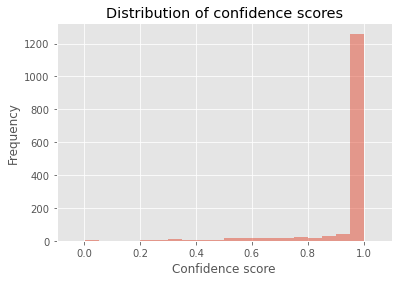

In [109]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

flat_scores_list = [j for sub in all_scores for j in sub] 

plt.xlim([min(flat_scores_list)-0.1, max(flat_scores_list)+0.1])
plt.hist(flat_scores_list, bins=20, alpha=0.5)
plt.title('Distribution of confidence scores')
plt.xlabel('Confidence score')
plt.ylabel('Frequency')

plt.show()
# If you don't see a plot initially, you may need to rerun this cell.

### Histogram of low confidence scores
Let’s filter out the high confidence scores to take a closer look at the lower ones. You can experiment with different thresholds to see how many words fall below that threshold.



In [111]:
THRESHOLD = 0.80

# Filter scores that are less than THRESHOLD
all_bad_scores = [i for i in flat_scores_list if i < THRESHOLD]
print(f"There are {len(all_bad_scores)} words that have confidence score less than {THRESHOLD}")

There are 134 words that have confidence score less than 0.8


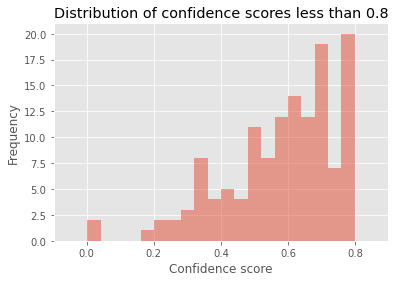

In [112]:
plt.xlim([min(all_bad_scores)-0.1, max(all_bad_scores)+0.1])
plt.hist(all_bad_scores, bins=20, alpha=0.5)
plt.title(f'Distribution of confidence scores less than {THRESHOLD}')
plt.xlabel('Confidence score')
plt.ylabel('Frequency')

plt.show()

We can see that there is a nontrivial number of words classified with low confidence. As we’ll see later, technical terms are more often mis-transcribed, so it’s important that we correct those mistakes.

## Step 2: Create human review workflows with A2I

Our next step is create a human review workflow that sends low confidence scores to human reviewers and then retrieves the corrected transcription they provide. This section contains the following steps:

1. Create a work task template that will be displayed to workers for every task. The template will be rendered with input data you provide, instructions to workers, and interactive tools to help workers complete your tasks.
2. Create a human review workflow, also called a flow definition. You use the flow definition to configure details about your human workforce and the human tasks they are assigned.
3. Create a human loop to start the human review workflow, sending data for human review as needed. In this example, you use a custom task type and start human loop tasks using the [Amazon A2I Runtime API](https://docs.aws.amazon.com/augmented-ai/2019-11-07/APIReference/Welcome.html). Each time `StartHumanLoop` is called, a task is sent to human reviewers.

## Create a Private Work Team 


A workforce is the group of workers that you have selected to label your dataset. You can choose either the Amazon Mechanical Turk workforce, a vendor-managed workforce, or you can create your own private workforce for human reviews. Whichever workforce type you choose, Amazon Augmented AI takes care of sending tasks to workers.

You can create a private workforce and add employeew to the work team. This will allow to send the A2I human review tasks to the team so  they can preview the worker UI and complete this demo. 

To create and manage your private workforce, you can use the Labeling workforces page in the Amazon SageMaker console. When following the instructions below, you will have the option to create a private workforce by entering worker emails or importing a pre-existing workforce from an Amazon Cognito user pool. To import a workforce, see Create a Private Workforce (Amazon Cognito Console). 

### To add yourself to an existing private workforce

If you have already created a private workforce in the same AWS Region as this notebook instance, [add yourself to a private team](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-workforce-management-private-console.html#add-remove-workers-sm) and copy and paste that work team ARN to set `WORKTEAM_ARN`.

Once you add yourself to the private workteam, you will recieve an email notifying you that you've been invited to the work team. Use the link in that email to reset your password and sign in to the worker portal. The worker portal is where the A2I human review tasks that you create in the following cells will appear. 

### To create a private workforce using worker emails:

You can create a private work team in the Amazon SageMaker console (approximately 15 minutes). 

* Open the **Labeling workforces page** page in the Amazon SageMaker console: https://console.aws.amazon.com/sagemaker/groundtruth#/labeling-workforces.


* If this notebook instance is not in N. Virginia (us-east-1), [change your AWS Region](https://docs.aws.amazon.com/awsconsolehelpdocs/latest/gsg/getting-started.html#select-region) to the same region that this notebook instance is in. 


* In the navigation pane, choose **Labeling workforces**.


* Choose **Private**, then choose **Create private team**.


* Choose **Invite new workers by email**.


* Add your email address and any others that you want to recieve the A2I human review tasks created in this demo. 
    * You will recieve an email notifying you that you've been invited to the work team. Use the link in that email to reset your password and sign in to the worker portal. The worker portal is where the A2I human review tasks that you create in the following cells will appear. 


* Enter an organization name and contact email.


* (Optionally) choose an SNS topic to subscribe the team to so workers are notified by email when new Ground Truth labeling jobs become available.


* Click the Create private team button.

After you import your private workforce, refresh the page. On the Private workforce summary page, you'll see your work team ARN. Enter this ARN in the following cell to set `WORKTEAM_ARN`.

In [113]:
WORKTEAM_ARN= "arn:aws:sagemaker:eu-central-1:733414849973:workteam/private-crowd/CrisTeam"

## Create Resources for an A2I Human Review
Now let's create the resources we'll need to build our human review workflow.

### Create Human Task UI

Amazon A2I uses Liquid, an open-source template language that can be used to “inject” data dynamically into HTML files.

In this walkthrough, we want for each task to enable a human reviewer to watch a section of the video and transcribe the speech they hear. The HTML template consists of three main parts:

1. A video player with a replay button that only allows the reviewer to play the specific subsection
2. A form for the reviewer to type and submit what they hear
3. Logic written in JavaScript to give the replay button its intended functionality

For over 60 other pre-built UIs, check out this [repository](https://github.com/aws-samples/amazon-a2i-sample-task-uis).

Here’s the template you’ll be using (skip ahead to the "Wait For Workers to Complete Task" section to preview what this template looks like):


In [114]:
template = r"""
<head>
    <style>
        h1 {
            color: black;
            font-family: verdana;
            font-size: 150%;
        }
    </style>
</head>
<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>

<crowd-form>
    <video id="this_vid">
        <source src="{{ task.input.filePath | grant_read_access }}"
            type="audio/mp4">
        Your browser does not support the audio element.
    </video>
    <br />
    <br />
    <crowd-button onclick="onClick(); return false;"><h1> Click to play video section!</h1></crowd-button>
    <br />
    Video title: <strong>{{ task.input.video_title }}</strong>
    <br />

    <h3>Instructions</h3>
    <p>Transcribe the audio clip </p>
    <p>The original transcript is <strong>"{{ task.input.original_words }}"</strong>.
    If the text matches the audio, you can copy and paste the same transcription.</p>
    <p>Ignore "umms", "hmms", "uhs" and other non-textual phrases.
    If a word is cut off in the beginning or end of the video clip, you do NOT need to transcribe that word.
    You also do NOT need to transcribe punctuation at the end of clauses or sentences.
    However, apostrophes and punctuation used in technical terms should still be included, such as "Denny's" or "file_name.txt"</p>
    <p><strong>Important:</strong> If you encounter a technical term that has multiple words,
    please <strong>hyphenate</strong> those words together. For example, "k nearest neighbors" should be transcribed as "k-nearest-neighbors."</p>
    <p>Click the space below to start typing.</p>
    <crowd-text-area name="transcription" rows="2" label="Your transcription" placeholder="Please enter the transcribed text."></crowd-text-area>

    <full-instructions header="Transcription Instructions">
        <h2>Instructions</h2>
        <p>Click the play button and listen carefully to the audio clip. Type what you hear in the box
            below. Replay the clip by clicking the button again, as many times as needed.</p>
    </full-instructions>

</crowd-form>

<script>
    var video = document.getElementById('this_vid');
    video.onloadedmetadata = function() {
        video.currentTime = {{ task.input.start_time }};
    };
    function onClick() {
        video.pause();
        video.currentTime = {{ task.input.start_time }};
        video.play();
        video.ontimeupdate = function () {
            if (video.currentTime >= {{ task.input.end_time }}) {
                video.pause()
            }
        }
    }
</script>
"""

def create_task_ui():
    '''
    Creates a Human Task UI resource.

    Returns:
    struct: HumanTaskUiArn
    '''
    response = sagemaker_client.create_human_task_ui(
        HumanTaskUiName=taskUIName,
        UiTemplate={'Content': template})
    return response

The `{{ task.input.filePath | grant_read_access }}` field grants access to and display a video using a path to the video’s location in an S3 bucket. To prevent the reviewer from navigating to irrelevant sections of the video, the `controls` parameter is omitted from the video tag and a single replay button is included to control which section can be replayed.

Below the video player, the `<crowd-text-area>` HTML tag creates a submission form that your reviewer will use to type and submit.

At the end of the HTML snippet, the `<script>` tag contains the logic for the replay button. The `{{ task.input.start_time }}` and `{{ task.input.end_time }}` fields allow you to inject the start and end times of the video subsection you want transcribed for the current task.

Now let's create a Human Task UI resource.

In [115]:
# Task UI name - this value is unique per account and region. You can also provide your own value here.
taskUIName = 'ui-transcribe-' + str(uuid.uuid4()) 

# Create task UI
humanTaskUiResponse = create_task_ui()
humanTaskUiArn = humanTaskUiResponse['HumanTaskUiArn']
print(humanTaskUiArn)

arn:aws:sagemaker:eu-central-1:733414849973:human-task-ui/ui-transcribe-8e58ff69-9be0-4782-a769-54cb664e497f


### Flow Definition

In this section, we're going to create a flow definition. Flow Definitions allow us to specify:

* The workforce that your tasks will be sent to.
* The instructions that your workforce will receive. This is called a worker task template.
* The configuration of your worker tasks, including the number of workers that receive a task and time limits to complete tasks.
* Where your output data will be stored.

This demo is going to use the API, but you can optionally create this workflow definition in the console as well.

For more details and instructions, see [Create a Flow Definition](https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-create-flow-definition.html).


In [116]:
# Flow definition name - this value is unique per account and region. You can also provide your own value here.
flowDefinitionName = 'demo-flowdef-transcribe-' + str(uuid.uuid4()) 

create_workflow_definition_response = sagemaker_client.create_flow_definition(
        FlowDefinitionName= flowDefinitionName,
        RoleArn= ROLE,
        HumanLoopConfig= {
            "WorkteamArn": WORKTEAM_ARN,
            "HumanTaskUiArn": humanTaskUiArn,
            "TaskCount": 1,
            "TaskDescription": "Identify the word(s) spoken in the provided audio clip",
            "TaskTitle": "DEMO: Determine Words/Phrases of Audio Clip: " + str(datetime.now())
        },
        OutputConfig={
            "S3OutputPath" : OUTPUT_PATH_A2I
        }
    )
flowDefinitionArn = create_workflow_definition_response['FlowDefinitionArn'] # let's save this ARN for future use

In [117]:
# Describe flow definition - status should be active
for x in range(60):
    describeFlowDefinitionResponse = sagemaker_client.describe_flow_definition(FlowDefinitionName=flowDefinitionName)
    print(describeFlowDefinitionResponse['FlowDefinitionStatus'])
    if (describeFlowDefinitionResponse['FlowDefinitionStatus'] == 'Active'):
        print("Flow Definition is active")
        break
    time.sleep(2)

Active
Flow Definition is active


## Human Loops
### Sending sequences of words/phrases of low confidence for review
After setting up our Flow Definition, we're ready to use Amazon Transcribe and initiate human loops. While iterating through the list of transcribed words and their confidence scores, we create a HumanLoop task whenever the confidence score is below some threshold, `CONFIDENCE_SCORE_THRESHOLD`.

An important thing to consider is how we deal with a low-confidence word that is part of a phrase that was also mis-transcribed. To handle these cases, let’s write a function that gets the sequence of words centered about a given index, and the sequence's starting and ending timestamps:

In [118]:
# Use this function to get the words near a word with poor confidence,
# since it is possible that the transcription also mis-transcribed nearby words/phrases
def get_word_neighbors(words, index, margin):
    """
    gets the words transcribe found at most `margin` away from the input index
    Returns:
        list: words at most 3 away from the input index
        int: starting time of the first word in the list
        int: ending time of the last word in the list
    """
    i = max(0, index - margin)
    j = min(len(words) - 1, index + margin)
    return words[i: j + 1], words[i]["start_time"], words[j]["end_time"]

Then, for every word we encounter with low confidence, we send its associated sequence of neighboring words for human review:

In [119]:
# Sample data, human loop started
human_loops_started = []
CONFIDENCE_SCORE_THRESHOLD = THRESHOLD
MARGIN = 5

count = 0
for index in range(num_videos):
    this_uri = folder_path+all_videos[index]
    this_confidences = all_confidences[index]
    
    print("========= " + all_videos[index] + " =========")
    
    i = 0
    while i < len(this_confidences):
        word = this_confidences[i]["content"]
        neighbors, start_time, end_time = get_word_neighbors(this_confidences, i, MARGIN)

        # Our condition for when we want to engage a human for review
        if (this_confidences[i]["confidence"] < CONFIDENCE_SCORE_THRESHOLD):

            # get the original sequence of words
            sequence = ""
            for block in neighbors:
                sequence += block['content'] + " "

            humanLoopName = str(uuid.uuid4())
            # "initialValue": word,
            inputContent = {
                "filePath": this_uri,
                "start_time": start_time,
                "end_time": end_time,
                "original_words": sequence,
                "video_title": all_videos[index]
            }
            start_loop_response = a2i.start_human_loop(
                HumanLoopName=humanLoopName,
                FlowDefinitionArn=flowDefinitionArn,
                HumanLoopInput={
                    "InputContent": json.dumps(inputContent)
                }
            )
            human_loops_started.append(humanLoopName)
            # print(f'Confidence score of {obj["confidence"]} is less than the threshold of {CONFIDENCE_SCORE_THRESHOLD}')
            # print(f'Starting human loop with name: {humanLoopName}')
            # print(f'Sending words from times {start_time} to {end_time} to review')
            print(f'The original transcription is "{sequence}"\n')
            
            count = count + 1
            
            # Advance to next word after the margin away from the low-confidence word
            i = i + MARGIN + 1
        else:
            # No human loop created, advance to next word.
            i = i + 1
            # print(f'Confidence score of {obj["confidence"]} is above threshold of {CONFIDENCE_SCORE_THRESHOLD}')
            # print('No human loop created. \n')
        

print(f'Number of tasks sent to review: {count}')

========= L'intervista a Francesco Starace amministratore delegato di Enel.mp4 =========
The original transcription is "dice che l'amministratore delegato dell'enel Benvenuto "

The original transcription is "sta succedendo No per niente È semplice la risposta Perché Perché "

The original transcription is "tanti motivi Diciamo per essere semplice diciamo Il paese in realtà "

The original transcription is "imboccato un periodo di crescita Può essere discusso di tanto di "

The original transcription is "tanto di poco di più o di meno C' è ancora "

The original transcription is "fare Abbiamo visto anche qualche necessità abbastanza importante Quindi c' è "

The original transcription is "importante Quindi c' è crescita cioè necessita di investimenti Mettiamoci a "

The original transcription is "che uno vuole fare prima quello che vuole fare Senta un "

The original transcription is "aumenta arrivano bollette Un po' più pesanti No è aumentata questo "

The original transcription is "u

Let's also save the name of each human loop, in case we need to retrieve them later after shutting down this notebook instance.

In [121]:
file_hl = open("human_loops_names.txt","w") 
for name in human_loops_started:
    file_hl.write(name + "\n") 
file_hl.close()
!cat human_loops_names.txt

215906c2-fc02-47d7-a432-797f0f665235
96de3488-7621-43eb-b606-83f763906711
c2df6938-c623-4bb7-b642-988bd9b98841
dd51823a-1800-4143-887c-4accd7f11bbe
afe5d784-3cfb-49a6-872e-28eb59bbe444
e48bd2a2-76bc-4506-bfac-999f24442f19
0342121c-0462-41dd-a4ce-5b2cb20dd9c7
8b2cfd50-7dfa-4b88-8b72-58db90778a1f
3b307fd9-7fcb-4922-9285-08db4170b1bb
c0d4cf40-7e26-41f3-891b-28ad499e9dc1
6dc66d57-fb8b-406c-9d1c-1e4a176ce14f
b3b6116e-f885-4a38-b288-d28fd5ba35b4
73bc6bb4-6ff5-4286-8069-f752956d845c
88c1764c-e13a-4e2a-88dd-43a051d8ed70
2589661f-75b6-4676-ba63-ea6b9a1a628f
3700effd-b928-445a-a84c-45531185bd96
65ebfa70-11d3-4bd2-996c-fc6b4981fab2
8f42c171-e36f-4f46-b9e1-6e4065e6399f
2db42c37-99ac-4971-9841-939b827bd91b
3373f2ae-554a-487e-b32c-07d0a9faca32
718bd575-6f59-434d-9e62-f92859d8a826
0bf458dc-6791-4107-a041-f0f5d304ba1c
afbd57df-9735-4012-afd7-fd59fdb9a626
378b7265-597e-4bb7-b222-631fca2cf529
a1f95c8d-826d-4c1d-b1f6-42bd282e927b
40e08091-99e3-4515-b880-5910afddda26
9c17e051-38c7-43e6-b4e6-8b59ad1c1fc5
f

### Check Status of Human Loop

In [122]:
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    # print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    # print('\n')

HumanLoop Name: 215906c2-fc02-47d7-a432-797f0f665235
HumanLoop Status: InProgress
HumanLoop Name: 96de3488-7621-43eb-b606-83f763906711
HumanLoop Status: InProgress
HumanLoop Name: c2df6938-c623-4bb7-b642-988bd9b98841
HumanLoop Status: InProgress
HumanLoop Name: dd51823a-1800-4143-887c-4accd7f11bbe
HumanLoop Status: InProgress
HumanLoop Name: afe5d784-3cfb-49a6-872e-28eb59bbe444
HumanLoop Status: InProgress
HumanLoop Name: e48bd2a2-76bc-4506-bfac-999f24442f19
HumanLoop Status: InProgress
HumanLoop Name: 0342121c-0462-41dd-a4ce-5b2cb20dd9c7
HumanLoop Status: InProgress
HumanLoop Name: 8b2cfd50-7dfa-4b88-8b72-58db90778a1f
HumanLoop Status: InProgress
HumanLoop Name: 3b307fd9-7fcb-4922-9285-08db4170b1bb
HumanLoop Status: InProgress
HumanLoop Name: c0d4cf40-7e26-41f3-891b-28ad499e9dc1
HumanLoop Status: InProgress
HumanLoop Name: 6dc66d57-fb8b-406c-9d1c-1e4a176ce14f
HumanLoop Status: InProgress
HumanLoop Name: b3b6116e-f885-4a38-b288-d28fd5ba35b4
HumanLoop Status: InProgress
HumanLoop Name: 

### Wait For Workers to Complete Task
We display the link to the private worker portal here for convenience. Check your email (or the email your worker provided) for the login information.

In [124]:
# Wait For Workers to Complete Task
workteamName = WORKTEAM_ARN[WORKTEAM_ARN.rfind('/') + 1:]
print("Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!")
print('https://' + sagemaker_client.describe_workteam(WorkteamName=workteamName)['Workteam']['SubDomain'])

Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!
https://q18mgti4iu.labeling.eu-central-1.sagemaker.aws


### Check Status of Human Loop Again
Human loop statuses that are completed will display `Completed` below. Note that it is not required to complete all human review tasks before continuing. Having 3-5 completed tasks is typically sufficient to see how technical terms can be extracted from the results.

In [125]:
completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    # print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    # print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)


HumanLoop Name: 215906c2-fc02-47d7-a432-797f0f665235
HumanLoop Status: Completed
HumanLoop Name: 96de3488-7621-43eb-b606-83f763906711
HumanLoop Status: Completed
HumanLoop Name: c2df6938-c623-4bb7-b642-988bd9b98841
HumanLoop Status: Completed
HumanLoop Name: dd51823a-1800-4143-887c-4accd7f11bbe
HumanLoop Status: Completed
HumanLoop Name: afe5d784-3cfb-49a6-872e-28eb59bbe444
HumanLoop Status: Completed
HumanLoop Name: e48bd2a2-76bc-4506-bfac-999f24442f19
HumanLoop Status: Completed
HumanLoop Name: 0342121c-0462-41dd-a4ce-5b2cb20dd9c7
HumanLoop Status: Completed
HumanLoop Name: 8b2cfd50-7dfa-4b88-8b72-58db90778a1f
HumanLoop Status: Completed
HumanLoop Name: 3b307fd9-7fcb-4922-9285-08db4170b1bb
HumanLoop Status: Completed
HumanLoop Name: c0d4cf40-7e26-41f3-891b-28ad499e9dc1
HumanLoop Status: Completed
HumanLoop Name: 6dc66d57-fb8b-406c-9d1c-1e4a176ce14f
HumanLoop Status: Completed
HumanLoop Name: b3b6116e-f885-4a38-b288-d28fd5ba35b4
HumanLoop Status: Completed
HumanLoop Name: 73bc6bb4-6ff

### View Task Results

Once work is completed, Amazon A2I stores results in your S3 bucket and sends a Cloudwatch event. Your results should be available in the S3 `OUTPUT_PATH` when all work is completed.

In [126]:
import re
import pprint

pp = pprint.PrettyPrinter(indent=4)

for resp in completed_human_loops:
    splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    pp.pprint(json_output['humanAnswers'][0]['answerContent'])

{}
{}
{}
{}
{}
{}
{   'transcription': "importante Quindi c' è crescita c' è necessita di "
                     'investimenti Mettiamoci a'}
{}
{}
{}
{}
{}
{}
{   'transcription': "si vanno a investire si trasformerà in un'auto elettrica "
                     'Allora anche lei'}
{}
{   'transcription': "l'auto elettrica ormai è arrivata ad una maturità "
                     'tecnologica Quindi è '}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{   'transcription': 'avrebbe permesso la gestione coordinata dei diversi '
                     'centri di produzione esistenti '}
{}
{   'transcription': 'il sud del paese collegato alle isole consentito '
                     'importazioni di'}
{}
{}
{}


## Step 3: Build custom vocabularies using A2I results

Using the corrected transcriptions from our human reviewers, let’s parse through these results to identify the domain-specific terms that we want to add to a custom vocabulary. 

### Retrieve A2I results
To get the technical terms identified by human review, we first accumulate all human-reviewed words into a list.

In [127]:
from string import punctuation

corrected_words = []

for resp in completed_human_loops:
    splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    
    # check if a transcription was submitted
    if 'transcription' in json_output['humanAnswers'][0]['answerContent']:
        # add the human-reviewed answers split by spaces
        corrected_words += [word.strip(punctuation).lower() for word in json_output['humanAnswers'][0]['answerContent']['transcription'].split(" ")]

# Sanity check!
print(corrected_words[0:5])

['importante', 'quindi', 'c', 'è', 'crescita']


### Filtering out common English words
Now, we want to parse through these words and look for “uncommon” English words. An easy way to do this is to use a large English corpus and verify whether each of our human-reviewed words exists in this corpus:

In [128]:
# Create dictionary of English words
# Note that this corpus of words is not 100% exhaustive
import nltk
nltk.download('words')

from nltk.corpus import words
my_dict=set(words.words()) 

[nltk_data] Downloading package words to /home/ec2-user/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [129]:
# Function for removing contractions
# Source: https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
def remove_contractions(word_list):
    return [word for word in word_list if word not in contractions]

### View Technical/Uncommon Words
After removing contractions, human-reviewed words that are not in the English language corpus are likely to be the technical terms we are looking for.

In [130]:
word_set = set([])
for word in remove_contractions(corrected_words):
    if word:
        if word.lower() not in my_dict:
            if word.endswith('s') and word[:-1] in my_dict:
                print("")
            elif word.endswith("'s") and word[:-2] in my_dict:
                print("")
            else:
                word_set.add(word)

In [131]:
for word in word_set:
    print(word)

importante
necessita
alle
consentito
una
investimenti
esistenti
permesso
elettrica
investire
centri
quindi
crescita
ormai
avrebbe
diversi
mettiamoci
è
l'auto
collegato
isole
allora
coordinata
tecnologica
anche
gestione
arrivata
dei
vanno
del
paese
il
trasformerà
un'auto
maturità
importazioni
produzione


### Create Custom Vocabulary
Using the technical terms identified above, it is now easier to manually create a custom vocabulary of those terms that we want Transcribe to be able to recognize. A custom vocabulary table enables options to tell Amazon Transcribe how each technical term is pronounced and how it should be displayed. More details on how to form a custom vocabulary table can be found at [Create a Custom Vocabulary Using a Table](https://docs.aws.amazon.com/transcribe/latest/dg/how-vocabulary.html#create-vocabulary-table).

Note that as you process additional videos on the same topic, you can keep updating this list, and the number of new technical terms you'll have to add will likely decrease each time you get a new video.

In [132]:
finalized_words=[['Phrase','IPA','SoundsLike','DisplayAs'], # This top line denote the column headers of the text file.
                 ['spm','','','SPM'],
                 #insert here your custom vocabulary 
                 
                ]





In this example, let's take a look at several phrases. The term "machine learning" in hyphenated in the first column to indicate that these two distinct words are pronounced. The `SoundsLike` column is left blank since both "machine" and "learning" are common words by themselves that Transcribe likely already knows how to pronounce.

The terms ECR, EBS, SDK, and other acronyms all should have periods after each letter in the `Phrase` column to denote that the letters are pronounced individually by name. This is reinforced in the `SoundsLike` column.

You'll also notice that hybrid acronym phrases like "opt-M.L." and "E.C.-Two" follow a combination of both conventions above.

Finally, the column corresponding to the IPA pronunciation is left blank for every word. The International Phonetic Alphabet (IPA) is the official standardized representation of the sounds of spoken language and may require some familiarity with phonetic notation. If you want to give Transcribe an extremely precise and unambiguous pronunciation guide, you can include IPA pronunciations instead of `SoundsLike` pronunciations by using an [IPA pronunciation key](https://en.wiktionary.org/wiki/Wiktionary:IPA_pronunciation_key) or looking them up in a dictionary.

### Write the Custom Vocabulary Table to a Txt File

In [133]:
custom_vocab_file_name = "customvocabtechnogym.txt"
file1 = open(custom_vocab_file_name,"w")
template = '{}\t{}\t{}\t{}\n'
for line in finalized_words:
    file1.write(template.format(line[0],
                                line[1],
                                line[2],
                                line[3])
               )
file1.close()

### Upload Custom Vocabulary File to S3

In [134]:
import logging
import boto3
from botocore.exceptions import ClientError


def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [135]:
upload_file(custom_vocab_file_name, BUCKET)

True

### Create the Custom Vocabulary for Amazon Transcribe
After saving your custom vocabulary table to a text file and uploading it to an S3 bucket, create your custom vocabulary with a specified name so that Amazon Transcribe can use it.

In [136]:
# The name of your custom vocabulary must be unique!
vocab_improved='sagemaker-custom-vocab-technogym' + str(uuid.uuid4())
vocab_improved

'sagemaker-custom-vocab-technogym7e2fb81a-cd03-4a0d-a863-59c811696e69'

In [137]:
transcribe_client = boto3.client("transcribe")
response = transcribe_client.create_vocabulary(
    VocabularyName=vocab_improved,
    LanguageCode='en-US',
    VocabularyFileUri='s3://' + BUCKET + '/' + custom_vocab_file_name
)
pp.pprint(response)

{   'LanguageCode': 'en-US',
    'ResponseMetadata': {   'HTTPHeaders': {   'connection': 'keep-alive',
                                               'content-length': '140',
                                               'content-type': 'application/x-amz-json-1.1',
                                               'date': 'Mon, 07 Feb 2022 '
                                                       '13:54:50 GMT',
                                               'x-amzn-requestid': 'a38d1746-5065-4a03-bd0e-bb977f01006e'},
                            'HTTPStatusCode': 200,
                            'RequestId': 'a38d1746-5065-4a03-bd0e-bb977f01006e',
                            'RetryAttempts': 0},
    'VocabularyName': 'sagemaker-custom-vocab-technogym7e2fb81a-cd03-4a0d-a863-59c811696e69',
    'VocabularyState': 'PENDING'}


Wait until the `VocabularyState` displays `READY` before continuing. This typically takes a few minutes or less.

In [138]:
# Wait for the status of the vocab you created to finish
while True:
    response = transcribe_client.get_vocabulary(
        VocabularyName=vocab_improved
    )
    status = response['VocabularyState']
    if status in ['READY', 'FAILED']:
        print(status)
        break
    print("Not ready yet...")
    time.sleep(5)

Not ready yet...
READY


## Step 4: Improve transcription using custom vocabulary

### Re-transcribe using the Custom Vocabulary
Let's re-transcribe the video using our custom vocabulary.

In [139]:
# New job names
# In-sample videos
job_name_custom_vid_0='AWS-custom-0-using-' + vocab_improved + str(time_now)
job_names_custom = [job_name_custom_vid_0]
job_names_custom

['AWS-custom-0-using-sagemaker-custom-vocab-technogym7e2fb81a-cd03-4a0d-a863-59c811696e6911.53.34']

### iterate on more videos

In [140]:
# You can give each transcription job any name. We attach a timestamp to each job name here
# to prevent conflicting job names in case we need to re-run any jobs.
#now = datetime.now()
#time_now = now.strftime("%H.%M.%S")

# Path to folder
#folder_path = f"s3://{BUCKET}/input_technogym/"

#job_names = []
#for i in range(num_videos):
#    job_names.append("AWS-technogym-cutom-vid-" + str(i) + "-" + str(time_now))

#job_names_custom

In [141]:
# Start another transcription job using your custom vocabulary.
transcribe(job_name_custom_vid_0, folder_path+all_videos[0], BUCKET, vocab_name=vocab_improved)

## Start a transcription job
for i in range(len(job_names)):
    transcribe(job_names[i], folder_path+all_videos_s3[i], BUCKET_OUTPUT, vocab_name=vocab_improved)

------mp4
An error occurred (BadRequestException) when calling the StartTranscriptionJob operation: The language used in the specified vocabulary doesn't match the specified language code.


NameError: name 'all_videos_s3' is not defined

At this point, it may have been some time since you've run the first few cells of this notebook. If you get the error `TypeError: 'TranscribeService' object is not callable`, your execution role may have expired. Refreshing the role connection using the cell below (after uncommenting) is typically able to resolve this issue. You may also need to re-run the cells containing the definition of the function `transcribe` (the first code cell of Step 1).

In [142]:
# from sagemaker import get_execution_role

# ROLE = get_execution_role()
# display(ROLE)

Check the status of your transcription job. Wait until the status displays `COMPLETED`.

In [143]:
while True:
    response = transcribe_client.get_transcription_job(
        TranscriptionJobName=job_name_custom_vid_0
    )
    status = response['TranscriptionJob']['TranscriptionJobStatus']
    if status in ['COMPLETED', 'FAILED']:
        print(status)
        break
    print("Not ready yet...")
    time.sleep(5)
    

BadRequestException: An error occurred (BadRequestException) when calling the GetTranscriptionJob operation: The requested job couldn't be found. Check the job name and try your request again.

In [144]:
all_entire_transcript_custom = []
all_sentences_and_times_custom = []
all_confidences_custom = []
all_scores_custom = []
num_videos=1
for i in range(num_videos):
    entire_transcript_1, sentences_and_times_1, confidences_1, scores_1 = get_transcript_text_and_timestamps(BUCKET,job_names_custom[i]+".json")
    all_entire_transcript_custom.append(entire_transcript_1)
    all_sentences_and_times_custom.append(sentences_and_times_1)
    all_confidences_custom.append(confidences_1)
    all_scores_custom.append(scores_1)

NoSuchKey: An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.

In [145]:
# View several sentences
print(all_sentences_and_times_custom[0][0:20])

IndexError: list index out of range

### Write the Improved Transcripts to Txt File

In [88]:
# Save the improved transcripts
i = 1
for list_ in all_sentences_and_times_custom:   
    file = open(f"improved_transcript_{i}.txt","w")
    for tup in list_:
        file.write(tup['sentence'] + "\n") 
    file.close()
    i = i + 1